In [1]:
from PIL import Image, ImageOps
from pathlib import Path

def insert_into_square_canvas(
        in_path: str | Path,
        out_path: str | Path,
        canvas_side: int = 512,
        bg_color: tuple[int, int, int] = (255, 255, 255)  # white
    ) -> None:
    """
    Open `in_path`, letter-box it into a `canvas_side`×`canvas_side` square and
    save to `out_path`.

    The original aspect ratio is preserved; no cropping or stretching occurs.
    """
    img = Image.open(in_path).convert("RGB")

    # --- resize keeping aspect ratio ----------------------------------------
    img.thumbnail((canvas_side, canvas_side), Image.Resampling.LANCZOS)

    # --- create square canvas and centre the image --------------------------
    canvas = Image.new("RGB", (canvas_side, canvas_side), color=bg_color)
    x = (canvas_side - img.width)  // 2
    y = (canvas_side - img.height) // 2
    canvas.paste(img, (x, y))

    # --- save ---------------------------------------------------------------
    canvas.save(out_path, quality=95)



In [14]:
import cv2
import pytesseract
import json
import os

# Set Tesseract executable path (required for Windows users)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to extract word-level bounding boxes and text using Tesseract
def extract_bounding_boxes(image_path, output_json_path, output_boxed_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to load image: {image_path}")
    h, w, _ = image.shape  # Get image dimensions

    # Perform OCR and extract data at the word level
    data = pytesseract.image_to_data(image, lang='sin', output_type=pytesseract.Output.DICT)

    bounding_box_data = []
    n_boxes = len(data["level"])
    for i in range(n_boxes):
        text = data["text"][i].strip()
        # Skip empty text results
        if text != "":
            left = data["left"][i]
            top = data["top"][i]
            width_box = data["width"][i]
            height_box = data["height"][i]
            # Create bounding box as [x_min, y_min, x_max, y_max]
            bbox = [left, top, left + width_box, top + height_box]
            bounding_box_data.append({
                "text": text,
                "bounding_box": bbox,
                "confidence": data["conf"][i]
            })

            # Draw bounding box on the image for visualization
            cv2.rectangle(image, (left, top), (left + width_box, top + height_box), (0, 255, 0), 2)
            cv2.putText(image, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Save bounding box data to a JSON file
    with open(output_json_path, 'w', encoding='utf-8') as json_file:
        json.dump(bounding_box_data, json_file, ensure_ascii=False, indent=4)
    print(f"Bounding boxes saved to: {output_json_path}")

    # Save the image with bounding boxes to a file 
    cv2.imwrite(output_boxed_path, image)
    print(f"Image with bounding boxes saved to: {output_boxed_path}")

# Main function to process images in a folder
def process_images(folder_path, output_folder_json, output_folder_boxed):
    if not os.path.exists(output_folder_json):
        os.makedirs(output_folder_json)
    if not os.path.exists(output_folder_boxed):
        os.makedirs(output_folder_boxed)

    for filename in os.listdir(folder_path):
        # Process common image file formats
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            output_json_path = os.path.join(output_folder_json, f"{os.path.splitext(filename)[0]}.json")
            output_boxed_path = os.path.join(output_folder_boxed, f"{os.path.splitext(filename)[0]}_boxed.jpg")
            
            # Check if the JSON file already exists
            if os.path.exists(output_json_path):
                print(f"Skipping {filename} as JSON file already exists: {output_json_path}")
                continue
            
            extract_bounding_boxes(image_path, output_json_path, output_boxed_path)


In [17]:
#libraries
import numpy as np
from numpy import linalg
import cv2
from math import sqrt
from math import atan
from math import pow
import matplotlib.pyplot as plt
import glob
from PIL import Image
from pathlib import Path

def binarize_and_save(in_path: str | Path,
        out_path: str | Path):

    #reading the image
    a = cv2.imread(str(in_path))

    #making 3 grayscale images 
    b = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    c = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    d = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)

    #k-value range [0.1-0.5] can be changed depending on image
    k=0.1

    #r-value can be changed depending on image
    r=128

    #neighbouring window size can be changed depending on image
    window=8

    #otsu thresholding
    ret2,th= cv2.threshold(b,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    h,w=b.shape

    th=0
    value=[]
    threshold=[]
    m=0
    var=0
    std=0
    b,c=cv2.integral2(b)

    h,w=c.shape

    #Sauvola Method using integrl images
    for i in range(1, w , 1):
        for j in range(1, h , 1):
            if(j>(h-int(window/2)) and i>(w-int(window/2))):
                m = (b[j, i] + b[j - int(window/2), i - int(window/2)] - b[
                    j , i - int(window/2)] - b[j - int(window/2), i]) / (window * window)
                s = (c[j, i] + c[j - int(window/2), i - int(window/2)] - c[
                    j, i - int(window/2)] - c[j - int(window/2), i]) / (window * window)
            elif (i > (w - int(window/2)) and j < (h - int(window/2))):
                m = (b[j + int(window/2), i] + b[j - int(window/2), i - int(window/2)] - b[
                    j + int(window/2), i - int(window/2)] - b[j - int(window/2), i]) / (window * window)
                s = (c[j + int(window/2), i] + c[j - int(window/2), i - int(window/2)] - c[
                    j + int(window/2), i - int(window/2)] - c[j - int(window/2), i]) / (window * window)
            elif(j>(h-int(window/2)) and i<(w-int(window/2))):
                m = ( b[j,i+int(window/2)]+b[j-int(window/2),i-int(window/2)]-b[j,i-int(window/2)]-b[j-int(window/2),i+int(window/2)])/(window*window)
                s = (  c[j,i+int(window/2)]+c[j-int(window/2),i-int(window/2)]-c[j,i-int(window/2)]-c[j-int(window/2),i+int(window/2)])/(window*window)
            elif(j<(h-int(window/2) ) and i<(w-int(window/2))):
                m=(b[j+int(window/2),i+int(window/2)]+b[j-int(window/2),i-int(window/2)]-b[j+int(window/2),i-int(window/2)]-b[j-int(window/2),i+int(window/2)])/(window*window)
                s=(c[j+int(window/2),i+int(window/2)]+c[j-int(window/2),i-int(window/2)]-c[j+int(window/2),i-int(window/2)]-c[j-int(window/2),i+int(window/2)])/(window*window)
            var = ((s)- (pow((m), 2)))/(window*window)
            std = sqrt(abs(var))
            T = m * (1 + (k * ((std / r) - 1)))
            threshold.append(T)




    h1,w1=d.shape

    #setting pixel values based on computed threshold
    for i in range(0, w1, 1):
        for j in range(0, h1, 1):

            if (d[j, i] <= threshold[th]):
                d[j, i] = 0
            else:
                d[j, i] = 255
            th=th+1
            
    for i in range(0, int(window/2), 1):
        for j in range(0, h1, 1):
            d[j,i]=255
    for i in range(0, w1, 1):
        for j in range(0, int(window/2), 1):
            d[j,i]=255
            

    
    # Save the image with binaized  
    cv2.imwrite(out_path, d)
    print(f"Image with bounding boxes saved to: {out_path}")

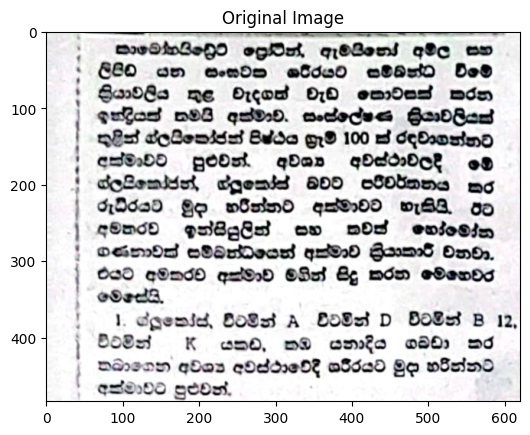

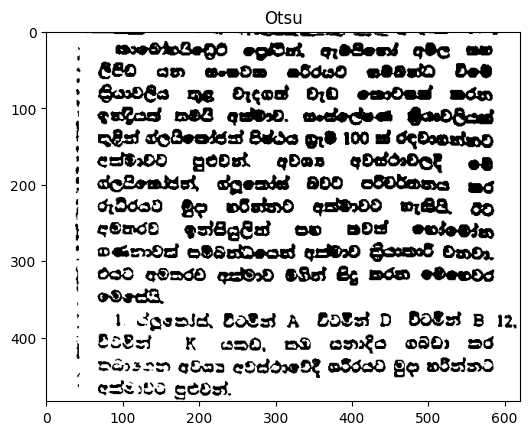

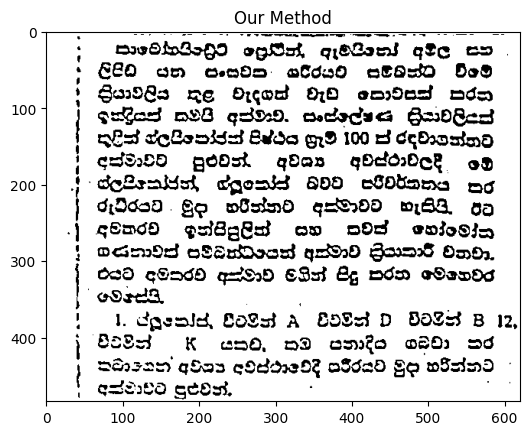

Image with bounding boxes saved to: D:\python\data\binarized_images\page_7_1.png


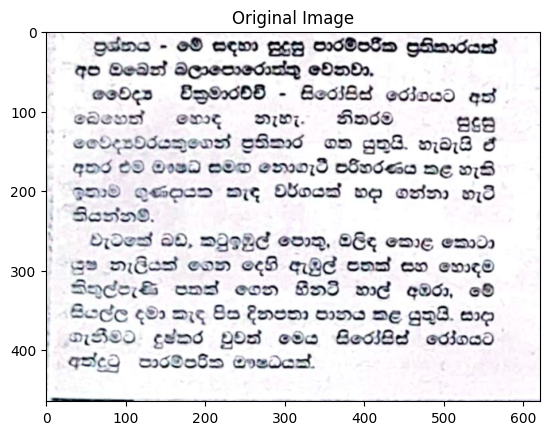

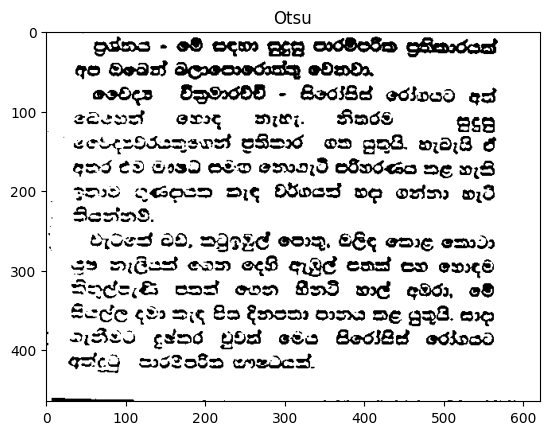

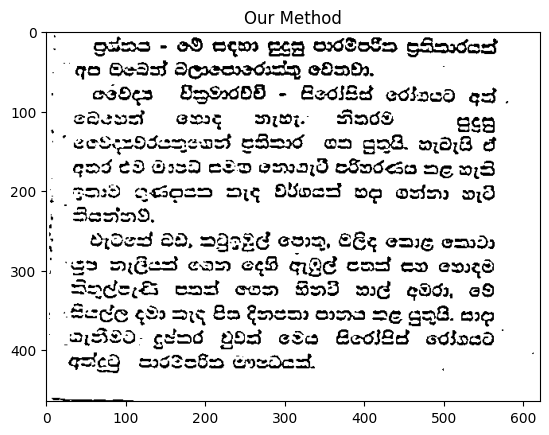

Image with bounding boxes saved to: D:\python\data\binarized_images\page_7_2.png
Bounding boxes saved to: D:\python\data\json\page_7_1.json
Image with bounding boxes saved to: D:\python\data\boxed\page_7_1_boxed.jpg
Bounding boxes saved to: D:\python\data\json\page_7_2.json
Image with bounding boxes saved to: D:\python\data\boxed\page_7_2_boxed.jpg


In [16]:
from glob import glob
import os

unedited_img_dir =  r"D:\python\data\images_unedited" 
binarized_img_dir =  r"D:\python\data\binarized_images" 
canvased_img_dir =  r"D:\python\data\images" 
os.makedirs(canvased_img_dir, exist_ok=True)

for fp in glob(f"{unedited_img_dir}/*.*"):
    fp_path = Path(fp)  # Convert string to Path object
    out_fp = Path(binarized_img_dir) / f"{fp_path.stem}.png"  # Ensure out_fp is a Path object
    binarize_and_save(fp_path, out_fp)  # Pass Path objects directly to the function


for fp in glob(f"{binarized_img_dir}/*.*"):
    fp_path = Path(fp)  # Convert string to Path object
    out_fp = os.path.join(canvased_img_dir, fp_path.stem + ".png")
    insert_into_square_canvas(fp, out_fp)

input_folder = r"D:\python\data\images"   # Replace with your folder containing images
output_json = r"D:\python\data\json"     # Replace with your output folder
output_boxed = r"D:\python\data\boxed"     # Replace with your output folder
process_images(input_folder, output_json, output_boxed)